In [1]:
# imports

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

from env import get_connection
import os

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#### Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

In [2]:
def acquire_grocery_data():
    
    '''read data from csv file of a local storage if exists. If csv file does not exist, read data from 
    server using SQL, write data into csv file for cache. Return a dataframe
    '''
    
    filename = 'grocerry.csv'
     
    if os.path.exists(filename):
        # read data from csv file of local storage
        df = pd.read_csv(filename)
    else: 
        query = '''
                SELECT *
                from grocery_customers
                '''

        url = get_connection('grocery_db')

        # read data from server using SQL
        df = pd.read_sql(query, url, index_col="customer_id")
        
        # write to data csv file for cache
        df.to_csv('grocerry.csv', index_label=False)
        
    return df

In [3]:
# acquire data
grocery_df = acquire_grocery_data()

In [4]:
# peak into data
grocery_df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
# create a dataframe  with columns selected for clustering
fresh_grocery_frozen =grocery_df[['Fresh','Grocery', 'Frozen']]

In [6]:
# peak into data
fresh_grocery_frozen.head()

,Fresh,Grocery,Frozen
0,12669,7561,214
1,7057,9568,1762
2,6353,7684,2405
3,13265,4221,6404
4,22615,7198,3915


In [7]:
# check data types
fresh_grocery_frozen.dtypes

Fresh      int64
Grocery    int64
Frozen     int64
dtype: object

In [8]:
# Make the scaler
scaler = MinMaxScaler()

# Use the scaler
fresh_grocery_frozen = scaler.fit_transform(fresh_grocery_frozen)
fresh_grocery_frozen

array([[0.11294004, 0.08146416, 0.0031063 ],
       [0.06289903, 0.10309667, 0.02854842],
       [0.05662161, 0.08278992, 0.03911643],
       ...,
       [0.1295431 , 0.32594285, 0.00677142],
       [0.091727  , 0.02402535, 0.01664914],
       [0.02482434, 0.02702178, 0.00065742]])

In [9]:
# add the scaled value columns back onto the dataframe
columns = ['Fresh','Grocery', 'Frozen']
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = grocery_df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(fresh_grocery_frozen, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
grocery_df = grocery_df.merge(scaled_df, on=grocery_df.index)
grocery_df = grocery_df.drop(columns=['key_0'])

In [10]:
# peak into data
grocery_df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Grocery,Scaled_Frozen
0,2,3,12669,9656,7561,214,2674,1338,0.112940,0.081464,0.003106
1,2,3,7057,9810,9568,1762,3293,1776,0.062899,0.103097,0.028548
2,2,3,6353,8808,7684,2405,3516,7844,0.056622,0.082790,0.039116
3,1,3,13265,1196,4221,6404,507,1788,0.118254,0.045464,0.104842
4,2,3,22615,5410,7198,3915,1777,5185,0.201626,0.077552,0.063934


In [11]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 10)

# Fit the object
dbsc.fit(fresh_grocery_frozen)

DBSCAN(eps=0.1, min_samples=10)

In [12]:
# create a columns with cluster labels
grocery_df['fgf_cluster_labels'] = dbsc.labels_

In [13]:
# peak into data
grocery_df.sample(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Grocery,Scaled_Frozen,fgf_cluster_labels
91,1,3,12754,2762,2530,8693,627,1117,0.113698,0.027237,0.142463,0
391,1,3,2647,2761,2313,907,95,1827,0.023576,0.024898,0.014496,0
213,1,1,3317,6602,6861,1329,3961,1215,0.029550,0.073919,0.021432,0
125,1,3,76237,3473,7102,16538,778,918,0.679762,0.076517,0.271399,-1
122,1,3,12212,201,245,1991,25,860,0.108865,0.002608,0.032312,0


In [14]:
# compute value_counts of cluster labesl
grocery_df.fgf_cluster_labels.value_counts()

 0    425
-1     15
Name: fgf_cluster_labels, dtype: int64

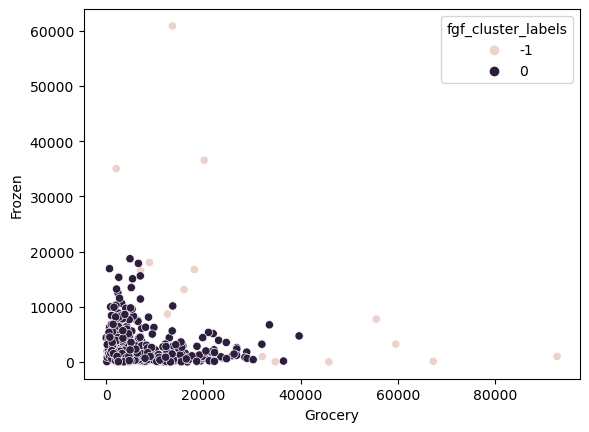

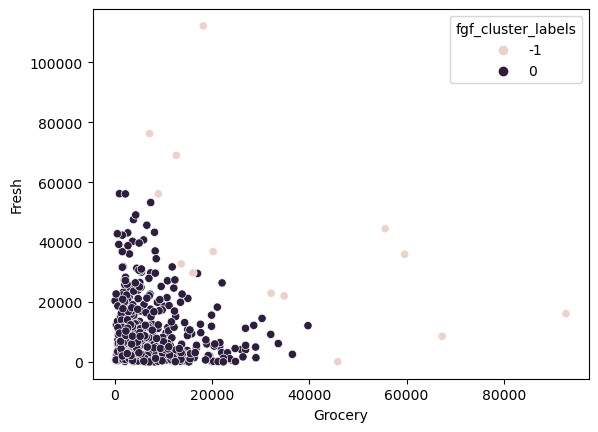

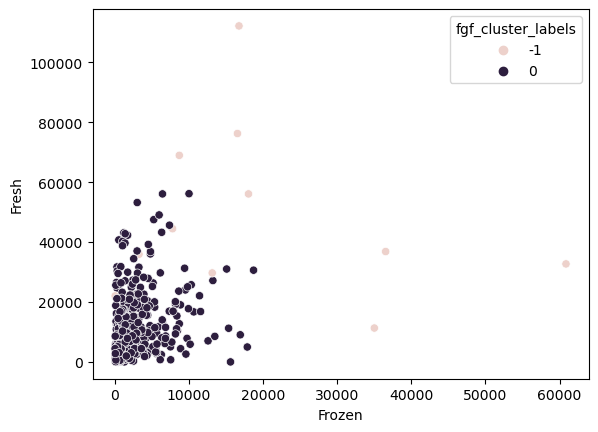

In [15]:
# plot graph
sns.scatterplot(x=grocery_df.Grocery, y=grocery_df.Frozen, hue=grocery_df.fgf_cluster_labels)
plt.show()

sns.scatterplot(x=grocery_df.Grocery, y=grocery_df.Fresh, hue=grocery_df.fgf_cluster_labels)
plt.show()

sns.scatterplot(x=grocery_df.Frozen, y=grocery_df.Fresh, hue=grocery_df.fgf_cluster_labels)
plt.show()

In [16]:
# get anomalies
grocery_anomalies = grocery_df.loc[grocery_df['fgf_cluster_labels'] == -1]

In [17]:
# get rows and columns 
grocery_anomalies.shape

(15, 12)

In [18]:
# peak into data
grocery_anomalies.sample(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Grocery,Scaled_Frozen,fgf_cluster_labels
435,1,3,29703,12051,16027,13135,182,2204,0.264829,0.172715,0.215469,-1
47,2,3,44466,54259,55571,7782,24171,6465,0.396467,0.598942,0.127490,-1
85,2,3,16117,46197,92780,1026,40827,2944,0.143685,1.000000,0.016452,-1
61,2,3,35942,38369,59598,3254,26701,2017,0.320460,0.642347,0.053070,-1
325,1,2,32717,16784,13626,60869,1272,5609,0.291704,0.146836,1.000000,-1


In [19]:
def get_anomolies_df(df, cols=[]):
    
#     # create a dataframe  with columns selected for clustering
    df_1 = df[cols]

    # Make the scaler
    scaler = MinMaxScaler()

    # Use the scaler
    df_1 = scaler.fit_transform(df_1)
    

    # add the scaled value columns back onto the dataframe
    scaled_columns = ["Scaled_" + column for column in cols]


    # Create a dataframe containing the scaled values
    scaled_df = pd.DataFrame(df_1, columns=scaled_columns)

    # Merge the scaled and non-scaled values into one dataframe
    df = df.merge(scaled_df, on=df.index)
    df = df.drop(columns=['key_0'])


    # Make the object
    dbsc = DBSCAN(eps = .10, min_samples = 10)

    # Fit the object
    dbsc.fit(df_1)

    # create a columns with cluster labels
    df['cluster_labels'] = dbsc.labels_

    

    # get anomalies
    df_anomalies = df.loc[df['cluster_labels'] == -1]
    
    return df_anomalies
    

In [20]:
grocery_df = acquire_grocery_data()
grocery_df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [21]:
get_anomolies_df(grocery_df,cols = ['Fresh','Grocery', 'Frozen'])

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Grocery,Scaled_Frozen,cluster_labels
47,2,3,44466,54259,55571,7782,24171,6465,0.396467,0.598942,0.127490,-1
61,2,3,35942,38369,59598,3254,26701,2017,0.320460,0.642347,0.053070,-1
65,2,3,85,20959,45828,36,24231,1423,0.000731,0.493926,0.000181,-1
85,2,3,16117,46197,92780,1026,40827,2944,0.143685,1.000000,0.016452,-1
86,2,3,22925,73498,32114,987,20070,903,0.204391,0.346109,0.015811,-1
93,1,3,11314,3090,2062,35009,71,2698,0.100858,0.022193,0.574979,-1
103,1,3,56082,3504,8906,18028,1480,2498,0.500045,0.095961,0.295888,-1
125,1,3,76237,3473,7102,16538,778,918,0.679762,0.076517,0.271399,-1
145,2,3,22039,8384,34792,42,12591,4430,0.196490,0.374974,0.000279,-1
181,1,3,112151,29627,18148,16745,4948,8550,1.000000,0.195576,0.274801,-1


#### Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [22]:
def acquire_curriculum_data():
    
    '''read data from csv file of a local storage if exists. If csv file does not exist, read data from 
    server using SQL, write data into csv file for cache. Return a dataframe
    '''
    
    filename = 'curriculum_logs.csv'
     
    if os.path.exists(filename):
        # read data from csv file of local storage
        df = pd.read_csv(filename)
    else: 
        query = '''
                SELECT *
                FROM logs
                '''

        url = get_connection('curriculum_logs')

        # read data from server using SQL
        df = pd.read_sql(query, url)
        
        # write to data csv file for cache
        df.to_csv('curriculum_logs.csv', index_label=False)
        
    return df
        
        

In [23]:
curriculum_df = acquire_curriculum_data()
curriculum_df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [24]:
curriculum_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       900223 non-null  object 
 1   time       900223 non-null  object 
 2   path       900222 non-null  object 
 3   user_id    900223 non-null  int64  
 4   cohort_id  847330 non-null  float64
 5   ip         900223 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 48.1+ MB


In [25]:
curriculum_df.isnull().sum()

date             0
time             0
path             1
user_id          0
cohort_id    52893
ip               0
dtype: int64

In [26]:
curriculum_df = curriculum_df.fillna(0)

In [27]:
curriculum_df.isnull().sum()

date         0
time         0
path         0
user_id      0
cohort_id    0
ip           0
dtype: int64

In [28]:
curriculum_df

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


In [29]:
def get_anomolies_df(df, cols=[]):
    
   # create a dataframe  with columns selected for clustering
    df_1 = df[cols]

    # Make the scaler
    scaler = MinMaxScaler()

    # Use the scaler
    df_1 = scaler.fit_transform(df_1)
    

    # add the scaled value columns back onto the dataframe
    scaled_columns = ["Scaled_" + column for column in cols]


    # Create a dataframe containing the scaled values
    scaled_df = pd.DataFrame(df_1, columns=scaled_columns)

    # Merge the scaled and non-scaled values into one dataframe
    df = df.merge(scaled_df, on=df.index)
    df = df.drop(columns=['key_0'])


    # Make the object
    dbsc = DBSCAN(eps = .10, min_samples = 10)

    # Fit the object
    dbsc.fit(df_1)

    # create a columns with cluster labels
    df['cluster_labels'] = dbsc.labels_

    

    # get anomalies
    df_anomalies = df.loc[df['cluster_labels'] == -1]
    
    return df_anomalies


In [30]:
df_1 = curriculum_df[['user_id', 'cohort_id']]

In [31]:
 scaler = MinMaxScaler()

    # Use the scaler
df_1 = scaler.fit_transform(df_1)
df_1

array([[0.        , 0.05755396],
       [0.        , 0.05755396],
       [0.        , 0.05755396],
       ...,
       [0.06428571, 0.20143885],
       [0.75816327, 0.20143885],
       [0.06428571, 0.20143885]])

In [32]:
cols = ['user_id', 'cohort_id']

In [33]:
# add the scaled value columns back onto the dataframe
scaled_columns = ["Scaled_" + column for column in cols]
scaled_columns

['Scaled_user_id', 'Scaled_cohort_id']

In [34]:
    # Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(df_1, columns=scaled_columns)
scaled_df 

,Scaled_user_id,Scaled_cohort_id
0,0.000000,0.057554
1,0.000000,0.057554
2,0.000000,0.057554
3,0.000000,0.057554
4,0.001020,0.158273
...,...,...
900218,0.064286,0.201439
900219,0.064286,0.201439
900220,0.064286,0.201439
900221,0.758163,0.201439


In [35]:
curriculum_df = curriculum_df.merge(scaled_df, on=curriculum_df.index)
curriculum_df = curriculum_df.drop(columns=['key_0'])
curriculum_df

,date,time,path,user_id,cohort_id,ip,Scaled_user_id,Scaled_cohort_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,0.000000,0.057554
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,0.000000,0.057554
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,0.000000,0.057554
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,0.000000,0.057554
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,0.001020,0.158273
...,...,...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33,0.064286,0.201439
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,0.064286,0.201439
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,0.064286,0.201439
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86,0.758163,0.201439
